# Training eines Neuronalen Netzes


## Aufbereitung der Daten


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
app_df = pd.read_csv('application_record.csv')
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
app_df.shape

(438557, 18)

In [4]:
credit_df = pd.read_csv('credit_record.csv')
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
credit_df.shape

(1048575, 3)

## Erklärung des Datensatzes:

Es gibt zwei Tabellen, die mithilfe der `ID` gemerged werden können. Die erste Tabelle app_df enthält alle Informationen eines Klienten mit seinen persönlichen Informationen und Daten.

- Diese Daten wurden von Kreditkartenantragstellern eingereicht, um die Wahrscheinlichkeit künftiger Zahlungsausfälle und Kreditkartenkredite vorherzusagen. Die Bank kann dann entscheiden, ob sie dem Antragsteller eine Kreditkarte ausstellt.
  Die zweite Tabelle enthält die Spalten `Months_Balance` und `Status`:

- `Months_Balance`: Der Monat is Startpunkt rückwärts --> 0 ist der aktuelle Monat, -1 ist der vorherige Monat usw.
- `Status`: <br>
  **0**: 1-29 Tage überfällig <br>
  **1**: 30-59 Tage überfällig <br>
  **2**: 60-89 Tage überfällig<br>
  **3**: 90-119 Tage überfällig<br>
  **4**: 120-149 Tage überfällig<br>
  **5**: Überfällige oder uneinbringliche Forderungen, Abschreibungen seit mehr als 150 Tagen<br>
  **C**: in diesem Monat getilgt<br>
  **X**: kein Kredit für den Monat<br>

Das folgende Skript verarbeitet die Kreditdaten, um festzustellen, ob ein Kunde kreditwürdig ist und wie hoch die "Good Rate" ist.<br>
Beim Status wird gezählt, wie oft eine Person pünktlich (Good) oder verspätet (Bad) bezahlt hat. Hat jemand mehr "Good"-Einträge als "Bad"-Einträge, gilt er demnach als "Good" <br>
Die Good Rate ist der relative Anteil der pünktlichen Zahlungen an allen Zahlungen eines Kunden


## Data Merging


In [6]:
#sorting IDs
app_df = app_df.sort_values('ID')
credit_df = credit_df.sort_values('ID')
#Map the status to bad or good
credit_df['STATUS_BINARY'] = credit_df['STATUS']
credit_df = credit_df.replace({'STATUS_BINARY' :{'C' : 'Good','X' : 'Good','0' : 'Bad', '1' : 'Bad','2' : 'Bad','3' : 'Bad','4' : 'Bad','5' : 'Bad'}}) #C und X sind Good, alle Zahlen 0-5 sind Schlecht
result_df = credit_df.value_counts(subset=['ID', 'STATUS_BINARY']).unstack(fill_value=0).reset_index() #für jede ID wird gezählt, wie viele Good und Bad Einträge es gibt
#decide the user is good or bad based on his/her history majority
result_df.loc[(result_df['Good'] / result_df['Bad'] >= 1), 'Status'] = 1 #Wenn eine ID mehr Good als Bad hat, wird der Gesamtstatus auf 1 gut gesetzt, sonst auf 0 schlecht
result_df.loc[(result_df['Good'] / result_df['Bad'] < 1 ), 'Status'] = 0
result_df['Status'] = result_df['Status'].astype(int)
df = app_df.merge(result_df, how='inner', on=['ID']) #Die zusammengefassten Kreditinformationen werden mit den Antragsdaten durch ID verknüpft
#define the rate of good debts for each user
df['Good rate'] = (df['Good']) / (df['Good'] + df['Bad']) #Spalte Rate wird erstellt, die das Verhältnis von Good zu Bad für jede ID darstellt. Wahrscheinlich wird +0.1 hinzugefügt, um Division durch 0 zu vermeiden
df.drop(['Good','Bad'],axis=1,inplace = True) #Spalten Good und Bad werden gelöscht
#Renaming columns to more friendly names
df.columns = ['ID', 'Gender', 'Car', 'Realty', 'Children', 'Income', 'Income_Type',
                        'Education_Type', 'Family_Status', 'Housing_Type',  'Age', 'Years_Experience' , 'Mobile_Phone', 'Work_Phone', 
                        'Phone', 'Email', 'Job_Title', 'Total_Family' , 'Status','Good rate']
df.head(5)

,ID,Gender,Car,Realty,Children,Income,Income_Type,Education_Type,Family_Status,Housing_Type,Age,Years_Experience,Mobile_Phone,Work_Phone,Phone,Email,Job_Title,Total_Family,Status,Good rate
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,0.875000
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,0.866667
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1,0.766667
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,0.600000
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,1.000000


## Handling Missing Values


In [7]:
df.isna().sum()

ID                      0
Gender                  0
Car                     0
Realty                  0
Children                0
Income                  0
Income_Type             0
Education_Type          0
Family_Status           0
Housing_Type            0
Age                     0
Years_Experience        0
Mobile_Phone            0
Work_Phone              0
Phone                   0
Email                   0
Job_Title           11323
Total_Family            0
Status                  0
Good rate               0
dtype: int64

In [8]:
print(df['Job_Title'].value_counts(dropna=False))


Job_Title
NaN                      11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: count, dtype: int64


In [9]:
#df.dropna()
df['Job_Title'] = df['Job_Title'].replace(r'^\s*$', np.nan, regex=True)
df['Job_Title'] = df['Job_Title'].fillna('unknown')


In [10]:
df.shape

(36457, 20)

## Convert Age and Years of Experience to year format


In [11]:
df['Age'] = df['Age']/(-1*365)
df['Years_Experience'] = df['Years_Experience']/(-1*365)
df.head(10)

,ID,Gender,Car,Realty,Children,Income,Income_Type,Education_Type,Family_Status,Housing_Type,Age,Years_Experience,Mobile_Phone,Work_Phone,Phone,Email,Job_Title,Total_Family,Status,Good rate
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.890411,12.443836,1,1,0,0,unknown,2.0,1,0.875000
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.890411,12.443836,1,1,0,0,unknown,2.0,1,0.866667
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.832877,3.106849,1,0,0,0,Security staff,2.0,1,0.766667
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,1,0,1,1,Sales staff,1.0,1,0.600000
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,1,0,1,1,Sales staff,1.0,1,1.000000
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,1,0,1,1,Sales staff,1.0,1,0.777778
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,1,0,1,1,Sales staff,1.0,1,0.846154
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.545205,-1000.665753,1,0,0,0,unknown,1.0,0,0.176471
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.545205,-1000.665753,1,0,0,0,unknown,1.0,0,0.176471
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,61.545205,-1000.665753,1,0,0,0,unknown,1.0,0,0.176471


## Behandlung Kategoriale Daten

Neuronale Netze können kategoriale Daten nicht direkt verbinden, sie müssen durch One-Hot-Encoding in eine numerische Darstellung umgewandelt werden


In [12]:
Cat_features = ['Realty', 'Gender','Car','Income_Type','Education_Type','Family_Status','Housing_Type','Job_Title']

for col in Cat_features: #Einblick in alle Kategorien, die in den Datenstehen
    print(col + ':', df[col].unique())

df.info()

Realty: ['Y' 'N']
Gender: ['M' 'F']
Car: ['Y' 'N']
Income_Type: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
Education_Type: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Family_Status: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
Housing_Type: ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
Job_Title: ['unknown' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   I

In [13]:
df_encoded = pd.get_dummies(df, columns=Cat_features, drop_first=True) #getDummies konvertiert so viele 0/1 Variabel als es verschiedene Values gibt, setzte drop_first = True damit keine doppelten oder überflüssigen Informationsspalten gibt

df_encoded.head(10)

,ID,Children,Income,Age,Years_Experience,Mobile_Phone,Work_Phone,Phone,Email,Total_Family,...,Job_Title_Low-skill Laborers,Job_Title_Managers,Job_Title_Medicine staff,Job_Title_Private service staff,Job_Title_Realty agents,Job_Title_Sales staff,Job_Title_Secretaries,Job_Title_Security staff,Job_Title_Waiters/barmen staff,Job_Title_unknown
0,5008804,0,427500.0,32.890411,12.443836,1,1,0,0,2.0,...,False,False,False,False,False,False,False,False,False,True
1,5008805,0,427500.0,32.890411,12.443836,1,1,0,0,2.0,...,False,False,False,False,False,False,False,False,False,True
2,5008806,0,112500.0,58.832877,3.106849,1,0,0,0,2.0,...,False,False,False,False,False,False,False,True,False,False
3,5008808,0,270000.0,52.356164,8.358904,1,0,1,1,1.0,...,False,False,False,False,False,True,False,False,False,False
4,5008809,0,270000.0,52.356164,8.358904,1,0,1,1,1.0,...,False,False,False,False,False,True,False,False,False,False
5,5008810,0,270000.0,52.356164,8.358904,1,0,1,1,1.0,...,False,False,False,False,False,True,False,False,False,False
6,5008811,0,270000.0,52.356164,8.358904,1,0,1,1,1.0,...,False,False,False,False,False,True,False,False,False,False
7,5008812,0,283500.0,61.545205,-1000.665753,1,0,0,0,1.0,...,False,False,False,False,False,False,False,False,False,True
8,5008813,0,283500.0,61.545205,-1000.665753,1,0,0,0,1.0,...,False,False,False,False,False,False,False,False,False,True
9,5008814,0,283500.0,61.545205,-1000.665753,1,0,0,0,1.0,...,False,False,False,False,False,False,False,False,False,True


In [14]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ID                                            36457 non-null  int64  
 1   Children                                      36457 non-null  int64  
 2   Income                                        36457 non-null  float64
 3   Age                                           36457 non-null  float64
 4   Years_Experience                              36457 non-null  float64
 5   Mobile_Phone                                  36457 non-null  int64  
 6   Work_Phone                                    36457 non-null  int64  
 7   Phone                                         36457 non-null  int64  
 8   Email                                         36457 non-null  int64  
 9   Total_Family                                  36457 non-null 

In [15]:
df_encoded.describe()

,ID,Children,Income,Age,Years_Experience,Mobile_Phone,Work_Phone,Phone,Email,Total_Family,Status,Good rate
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,43.767598,-162.364207,1.0,0.225526,0.294813,0.089722,2.198453,0.554160,0.511533
std,4.187524e+04,0.742367,1.017892e+05,11.508356,377.126945,0.0,0.417934,0.455965,0.285787,0.911686,0.497065,0.352356
min,5.008804e+06,0.000000,2.700000e+04,20.517808,-1000.665753,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,34.142466,1.117808,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.157895
50%,5.074614e+06,0.000000,1.575000e+05,42.638356,4.252055,1.0,0.000000,0.000000,0.000000,2.000000,1.000000,0.545455
75%,5.115396e+06,1.000000,2.250000e+05,53.254795,8.638356,1.0,0.000000,1.000000,0.000000,3.000000,1.000000,0.830508
max,5.150487e+06,19.000000,1.575000e+06,68.909589,43.049315,1.0,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000


## Definition von Features (X) und Zielvariable (y)


In [16]:
X = df_encoded.drop(['ID', 'Status'], axis=1) #ID und Status sind keine Features
y = df_encoded['Status'] #Zielvariable

#Aufteilung der Daten in Trainings- und Testsets

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y) #stratify=y Versuche die prozentuale Verteilung der Klassen in y_train und y_test so ähnlich wie möglich zu halten wie in y

#Skalierung der numerischen Spalten (Ursprüngliche numerische Spalten in df, die nicht entfernt wurden)

numeric_features = ['Children', 'Income', 'Age', 'Years_Experience', 'Total_Family', 'Good rate']

scaler = StandardScaler()

#Numerische Spalten im Trainingsset fitten und transformieren
X_train_full[numeric_features] = scaler.fit_transform(X_train_full[numeric_features])

# Die gleichen Statistiken des Trainingsset verwenden um das Testset zu transformieren
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


#Aufteilung des X_train_full in echtes Training und Validierung
#test_size = 25% von X_train_full

X_train, X_val, y_train, y_val=train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=50, stratify=y_train_full
)

# --- Finale Überprüfung der Shapes ---
print("\n--- Finale Shapes der Daten-Sets ---")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


--- Finale Shapes der Daten-Sets ---
X_train: (21873, 48), y_train: (21873,)
X_val: (7292, 48), y_val: (7292,)
X_test: (7292, 48), y_test: (7292,)


Der StandardScaler transformiert die numerischen Features, sodass sie einen MIttelwert von 0 und eine Standardabweichung von 1 aufweisen.
Unterschiedliche Wertebereiche von Feastures können die Loss-Functions wie Adam verzerren, was den Optimierer verlangsamt und das Training instabil macht. Mit der Skalierung sorgt man für eine gleichmäßige Landschaft, was die Konvergenz beschleunigt. Weiterhin sind Funktionen wie ReLU oder Sigmoid empfindlich gegenüber der Größe der Eingaben. Extreme Werte führen dazu, dass die Gradienten verschwinden.


Modellbau, Training und Evaluierung des Neuronalen Netzwerks

- input_shape
- Dense: Schichten, Anzahl der Neuronen festlegen
- activation: softmax Funktion
- Dropout: layers.Dropout einfügen, um Overfitting zu reduzieren

Wie soll Dense eingestellt werden?


In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers


In [18]:
#Clear Session with Keras?

num_features = X_train.shape[1] #Gesamtanzahl der Features von X_train

model = keras.Sequential(name="CreditModel") #Aufeinanderfolgen von verschiedenen Schichten "Dense", Daten fließen von erster bis zur letzten Ausgabeschicht
model.add(keras.Input(shape=(num_features,)))
model.add(layers.Dense(128, activation='relu')) #gängige Praxis Kombination von RelU und Sigmoid: in den "hidden"-layers: 
#es löst kritische Probleme der Gradientenverteilung und Recheneffizienz, Sigmoid interpretiert die Ergebnisse für binäre KLassifikationsprobleme als Wahrscheinlichkeiten
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid')) #Sollte nicht lieber sigmoid als Aktivierungsfunktion benutzt werden und nicht softmax?
# wir wollen ja nur 2 mögliche Klassen ausgeben, bei SOftmax wird eine Liste von Wahrscheinlichkeiten produziert, die sich zu 1 summieren


model.summary()

Model: "CreditModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)

## Beschreibung Model-Summary

- Param# bei dense ergibt sich aus der Anzahl der Features: num_features \* 128 + 128 = 6144
- Also Berechnung Anzahl = (Anzahl der Eingangsneuronen \* Anzahl der Ausgangsneuronen) + Anzahl der Ausgangsneuronen (für Biases)
- Params sind Gewichte und Biases


## Kompilieren des Modells mit Optimierer, Loss-Funktionen und Metriken wie Accuracy

- Optimizer: adam? Standardwahl
- loss: binary_crossentropy: Standard für binäre Klassifizierung
- metrics: accuracy


In [19]:
model.compile(

    optimizer = 'adam', #AdamOptimizer
    loss = 'binary_crossentropy', #Loss-Funktion für binäre Klassifikation bei Sigmoid
    metrics=[
        'accuracy' #Grundlegende Genauigkeit
    ]
)

## Modelltraining

Training des Modelles durch Wiederholung der Trainingsdaten: Nutzung der Epochen und Batches als auch Validierung

- epochs
- batch_size
- validation_split
- history-Object zum Speichern der Trainings- und Validierungsmetriken jeder Epoche


Callback für das Training


In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(#Beendet das Training, wenn der Validierungs-Loss sich nicht mehr verbessert
    monitor = 'val_loss', #Überwacht den Validierungs-loss
    patience = 10, #ANzahl der Epochen ohne Verbesserung, bevor gestoppt wird
    restore_best_weights=True, #Wiederherstellung der besten Modellgewichte der besten Epoche
    verbose=1 #Anzeigen, wann Early Stopping greift
)

In [21]:
print("n\Starte Modelltraining...")
history = model.fit(X_train, y_train,
                    epochs=100, #hohe Anzahl von Epochen, aber das Early Stopping soll das tatsächliche Ende regeln
                    batch_size=32, #Anzahl der Trainingsbeispiele pro Update des Modells
                    validation_data = (X_val, y_val), #Validierungsdaten für Training
                    #class_weight=class_weight,
                    callbacks=[early_stopping], #einsetzten EarlyStopping
                    verbose=1 #Anzeigen Trainingsfortschritt
                    )
print("Modelltraining abgeschlossen")

n\Starte Modelltraining...
Epoch 1/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9050 - loss: 0.2155 - val_accuracy: 0.9765 - val_loss: 0.0455
Epoch 2/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9860 - loss: 0.0418 - val_accuracy: 0.9952 - val_loss: 0.0178
Epoch 3/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9900 - loss: 0.0233 - val_accuracy: 0.9940 - val_loss: 0.0135
Epoch 4/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9925 - loss: 0.0192 - val_accuracy: 0.9968 - val_loss: 0.0091
Epoch 5/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9963 - loss: 0.0113 - val_accuracy: 0.9982 - val_loss: 0.0058
Epoch 6/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9950 - loss: 0.0117 - val_accuracy: 0.9973 - val_loss: 0.0066
Epoch 7/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9983 - loss: 0.0055 - val_accuracy: 0.9973 - val_loss: 0.0062
Epoch 8/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.998

## Visualisierung Trainingshistorie


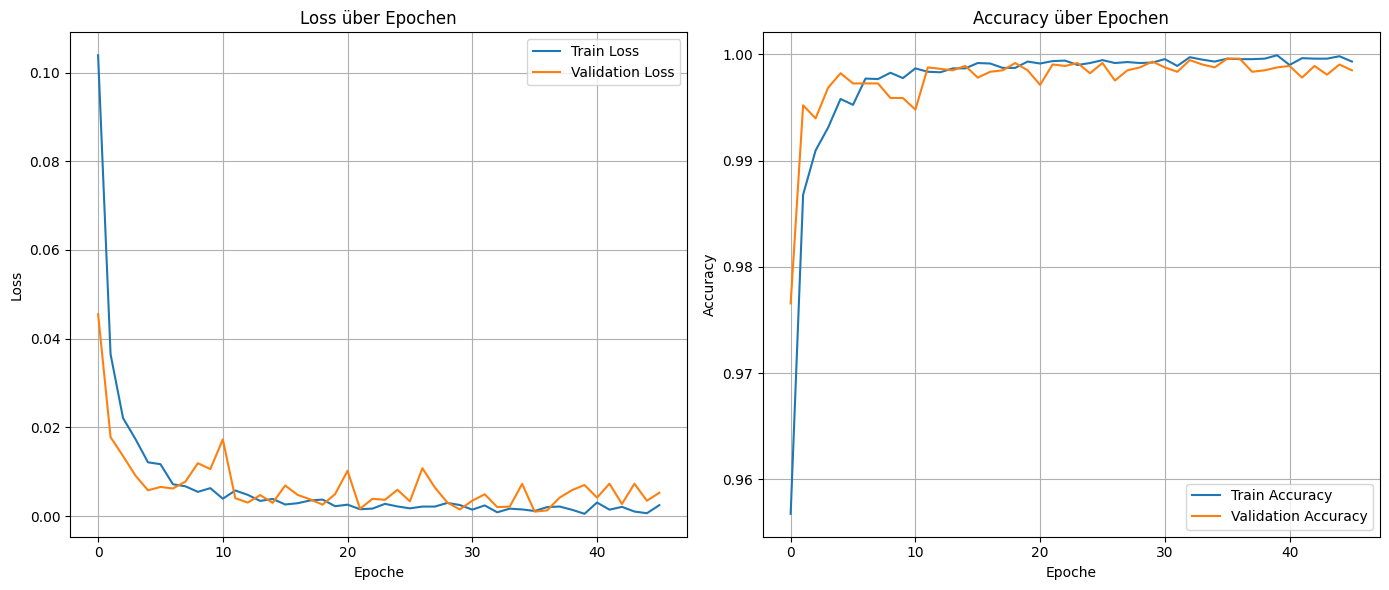

In [22]:
plt.figure(figsize=(14,6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation

mithilfe von Loss und Accuracy

- Visualsierung mithilfe eines Plots
- Plot von loss vs. val_loss
- Plot ovn accuracy vs. val_accuracy
- wenn val_loss nach eine Weile wieder ansteigt, während loss weiter sinkt, ist das Zeichen für Overfitting


In [23]:
print("\nModell auf Testdaten evaluieren:")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\nEvaluierungsergebnisse auf den Testdaten:")
print(f"    Loss: {loss:.4f}")
print(f"    Accuracy: {accuracy:.4f}")


Modell auf Testdaten evaluieren:

Evaluierungsergebnisse auf den Testdaten:
    Loss: 0.0023
    Accuracy: 0.9995


Beim Bemerken, dass der Trainings-Loss sinkt, aber der Validierungs Loss nach einer Weile wieder steigt, ist das ein Zeichen von Overfitting. Man kann Dropout in Keras verwenden direkt nach Dense-Schichten


Vorhersage treffen auf neue Daten, Finale Evaluierung des Modells (mit dem ungesehen Testset)

- ausschließlich X_test und y_test verwenden
- evaluate-Methode gibt den finalen Loss und die Metriken zurück


Einfache Methode um Layers linear zu stacken ist mithilfe der Sequential API:

Functional API bietet mehr Flexibilität um Modell zu defineiren mit mehreren Inputs/Outputs


In [24]:
'''
Sequential API

model = keras.Sequential()
model.add(keras.layers.Dense(16, activation='softmax', input_shape=(784,)))
model.add(keras.layers.Dense(8, activation='softmax'))
model.add(keras.layers.Dense(4, activation='softmax'))
print(model.summary())

Functional API

m1_layer1 = keras.layers.Dense(12, activation='softmax')(m1_inputs)
m1_layer2 = keras.layers.Dense(4, activation='softmax')(m1_layer1)
m2_layer1 = keras.layers.Dense(12, activation='softmax')(m2_inputs)
m2_layer2 = keras.layers.Dense(4, activation='softmax')(m2_layer1)
merged = keras.layers.add([m1_layer2, m2_layer2])
model = keras.Model(inputs=[m1_inputs, m2_inputs], outputs=merged)
print(model.summary())

'''

"\nSequential API\n\nmodel = keras.Sequential()\nmodel.add(keras.layers.Dense(16, activation='softmax', input_shape=(784,)))\nmodel.add(keras.layers.Dense(8, activation='softmax'))\nmodel.add(keras.layers.Dense(4, activation='softmax'))\nprint(model.summary())\n\nFunctional API\n\nm1_layer1 = keras.layers.Dense(12, activation='softmax')(m1_inputs)\nm1_layer2 = keras.layers.Dense(4, activation='softmax')(m1_layer1)\nm2_layer1 = keras.layers.Dense(12, activation='softmax')(m2_inputs)\nm2_layer2 = keras.layers.Dense(4, activation='softmax')(m2_layer1)\nmerged = keras.layers.add([m1_layer2, m2_layer2])\nmodel = keras.Model(inputs=[m1_inputs, m2_inputs], outputs=merged)\nprint(model.summary())\n\n"

# Federated Machine Learning
